Introduction to GeoPandas
=========================

[Serge Rey](http://sergerey.org)

The second library in the Python geospatial stack that we examine is
[GeoPandas](http://geopandas.org/). GeoPandas builds on the capabilities
of Shapely and combines these with the popular
[pandas](http://pandas.pydata.org) library that provides
high-performance and easy-to-use data structures for data analysis in
Python.

Objectives
----------

-   Understand GeoDataSeries and GeoDatatFrames
-   Learn reading and writing common vector spatial data formats
-   Carry out geoprocessing with GeoPandas

Setup and Imports
-----------------

We utilize our common imports

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

and import geopandas as an alias `gpd`

In [2]:
import geopandas as gpd

GeoPandas Structure
===================

As mentioned above, geopandas builds on-top of shapely which means we
have access to all the functionality we saw in the previous notebook. To
get a better sense of this connection, let\'s create a few shapely
Polygons and then see how they are used in geopandas:

In [3]:
from shapely.geometry import Polygon
poly_1 = Polygon([ (0,0), (0,10), (10, 10), (10, 0) ] )
poly_2 = Polygon([ (10,0), (10,10), (20, 10), (20, 0) ] )
poly_3 = Polygon([ (20,0), (20,10), (30, 10), (30, 0) ] )

GeoSeries: Putting the Geo in GeoPandas
---------------------------------------

We are going to combine these three polygons in a geopandas `GeoSeries`:

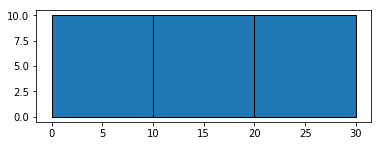

In [4]:
polys = gpd.GeoSeries([poly_1, poly_2, poly_3])
polys.plot(edgecolor='k')

The `GeoSeries` can be thought of as a vector, with each element of the
vector corresponding to one or more Shapely geometry objects:

In [5]:
polys

0       POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))
1    POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))
2    POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))
dtype: object

so here we see three elements, each of type `POLYGON` along with their
coordinates.

In [6]:
type(polys)

geopandas.geoseries.GeoSeries

Depending on what we need, we can either work on an *element-wise* basis
or with the geoseries as a unified object. For example, an example of
the former is:

In [7]:
polys.bounds

,minx,miny,maxx,maxy
0,0.0,0.0,10.0,10.0
1,10.0,0.0,20.0,10.0
2,20.0,0.0,30.0,10.0


which returns the bounds of each of the polygons. Alternatively, if we
want the bounds for the collection:

In [8]:
polys.total_bounds

array([ 0.,  0., 30., 10.])

Binary operations between two geoseries will be carried out element
wise, and this can lead to some counter intuitive results. For example,
a second `GeoSeries` created as:

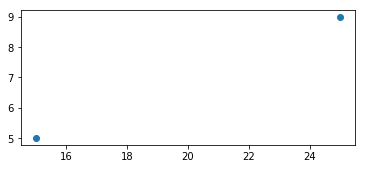

In [9]:
from shapely.geometry import Point
p_1 = Point(15, 5)
p_2 = Point(25, 9)
points = gpd.GeoSeries([p_1, p_2])
points.plot()

consists of two points. Each of the points is contained by the `polys`
`GeoSeries`:

In [10]:
polys.contains(p_1)

0    False
1     True
2    False
dtype: bool

and

In [11]:
polys.contains(p_2)

0    False
1    False
2     True
dtype: bool

Plotting the two `GeoSeries` confirms this:

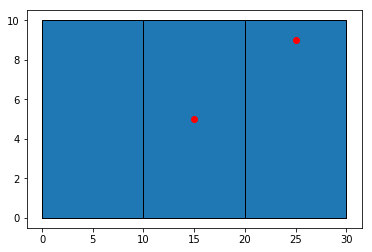

In [12]:
ax = plt.gca()
polys.plot(ax=ax, edgecolor='k')
points.plot(ax=ax, edgecolor='r', facecolor='r')
plt.show()

Yet, when we check if the points as a `GeoSeries` are contained by the
`polys` `GeoSeries` we get:

In [13]:
polys.contains(points)

0    False
1    False
2    False
dtype: bool

This is because the first point is not contained in the first polygon,
and the second point is not contained in the second polygon, while there
is no third point.

A second point geoseries can clarify this:

In [14]:
points = gpd.GeoSeries([Point(5,5), Point(15, 6), Point([25,9])])
polys.contains(points)

0    True
1    True
2    True
dtype: bool

whereas if we change the ordering of the second and third points we get:

In [15]:
points = gpd.GeoSeries([Point(5,5), Point(25, 9), Point([15,6])])
polys.contains(points)

0     True
1    False
2    False
dtype: bool

GeoDataFrame: Putting the Panda in GeoPandas
--------------------------------------------

-   geometry column is populated with a geoseries
-

In [16]:
polys_df = gpd.GeoDataFrame({'names': ['west', 'central', 'east'], 'geometry': polys})
polys_df

,geometry,names
0,"POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))",west
1,"POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))",central
2,"POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))",east


The dataframe provides the ability to add add additional columns:

In [17]:
polys_df['Unemployment'] = [ 7.8, 5.3, 8.2]
polys_df

,geometry,names,Unemployment
0,"POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))",west,7.8
1,"POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))",central,5.3
2,"POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))",east,8.2


and it supports different types of subsetting and traditional (i.e.,
nonspatial) queries. For example, find the regions with unemployment
rates above 6 percent:

In [18]:
polys_df[polys_df['Unemployment']>6.0]

,geometry,names,Unemployment
0,"POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))",west,7.8
2,"POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))",east,8.2


There is nothing sacred about the column labeled \'geometry\' in the
GeoDataFrame. Moreover, we can add additional GeoSeries to the same
dataframe, as they will be treated as regular columns. However, only one
GeoSeries can serve as the column against which any spatial methods are
applied when called upon. This column can be accessed through the
`geometry` attribute of the `GeoDataFrame`:

In [19]:
polys_df.geometry

0       POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))
1    POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))
2    POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))
Name: geometry, dtype: object

Let\'s create a new Points GeoSeries and add it to this GeoDataFrame as
a regular column:

In [20]:
points = gpd.GeoSeries([Point(5,5), Point(15, 6), Point([25,9])])
polys_df['points'] = points
polys_df.geometry

0       POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))
1    POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))
2    POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))
Name: geometry, dtype: object

So the `polys` column is currently serving as the `geometry` property
for the `GeoDataFrame` and `points` is just another column:

In [21]:
polys_df

,geometry,names,Unemployment,points
0,"POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))",west,7.8,POINT (5 5)
1,"POLYGON ((10 0, 10 10, 20 10, 20 0, 10 0))",central,5.3,POINT (15 6)
2,"POLYGON ((20 0, 20 10, 30 10, 30 0, 20 0))",east,8.2,POINT (25 9)


so when we call the `plot` method we get the polygon representation:

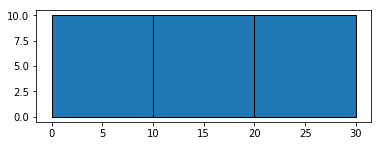

In [22]:
polys_df.plot(edgecolor='k')

However, if we explicity set the geometry property (and assign this to a
new object with the same name), and plot, things change:

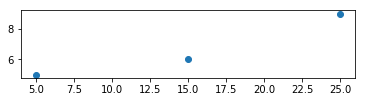

In [23]:
polys_df = polys_df.set_geometry('points')
polys_df.plot()

and this is because

In [24]:
polys_df.geometry

0     POINT (5 5)
1    POINT (15 6)
2    POINT (25 9)
Name: points, dtype: object

Read a Polygon Shapefile
========================

In [25]:
tracts_df = gpd.read_file('data/california_tracts.shp')

In [26]:
tracts_df.head()

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,...,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,geometry
0,06083002103,Census Tract 21.03,2838200.0,7603.0,+34.9306689,-120.4270588,3930,354,290,253,...,1469,476,993,1360,2492,2.86,2.51,0.069451,0.000281,"POLYGON ((-120.417938 34.93834100000004, -120...."
1,06083002402,Census Tract 24.02,16288573.0,44468.0,+34.9287963,-120.4780833,11406,1250,1099,969,...,2920,1444,1476,5161,6240,3.57,4.23,0.190631,0.001611,POLYGON ((-120.4738929999999 34.92081400000006...
2,06083002102,Census Tract 21.02,1352551.0,0.0,+34.9421111,-120.4267767,2084,156,141,139,...,739,433,306,1179,905,2.72,2.96,0.051289,0.000133,"POLYGON ((-120.417658 34.93834500000003, -120...."
3,06083002010,Census Tract 20.10,2417990.0,0.0,+34.8714281,-120.4100285,4375,215,264,341,...,1522,1303,219,3609,761,2.77,3.47,0.066269,0.000238,"POLYGON ((-120.411468 34.87961900000005, -120...."
4,06083002009,Census Tract 20.09,2603281.0,0.0,+34.8722878,-120.4277159,3826,170,232,318,...,1326,969,357,2730,1045,2.82,2.93,0.065523,0.000257,"POLYGON ((-120.423524 34.87928299999999, -120...."


In [27]:
tracts_df.shape

(8057, 195)

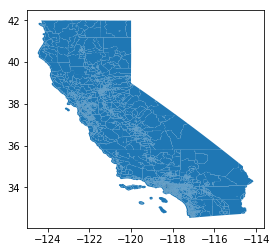

In [28]:
tracts_df.plot()

In [29]:
tracts_df.crs

{'init': 'epsg:4269'}

In [30]:
tracts_df.columns

Index(['GEOID10', 'NAMELSAD10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'DP0010001', 'DP0010002', 'DP0010003', 'DP0010004',
       ...
       'DP0210001', 'DP0210002', 'DP0210003', 'DP0220001', 'DP0220002',
       'DP0230001', 'DP0230002', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=195)

Read a Point Shapefile
======================

In [31]:
clinics_df = gpd.read_file('data/behavioralHealth.shp')

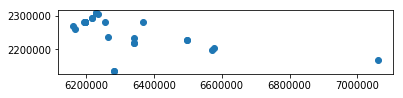

In [32]:
clinics_df.plot()

In [33]:
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [34]:
clinics_df.shape

(28, 8)

In [35]:
clinics_df['geometry'].head()

0    POINT (6216487.156141102 2291913.663858846)
1    POINT (6195566.225542113 2280519.189600602)
2    POINT (6168252.101364687 2261023.951032102)
3    POINT (7059944.605377689 2169652.045521691)
4    POINT (6195949.671953693 2280510.302151188)
Name: geometry, dtype: object

What we want to do now is focus on the relationships between the
locations of these clinics in Riverside county and the census tracts in
that county. We have two issues to deal with in order to do so.

First, our dataframe for the tracts includes all 58 counties, whereas we
only need Riverside county. Second, if you look closely at the plot of
the clinics you will see that the units on the axes are different from
those in the plot of the census tracts. This is because the two
dataframes have different coordinate reference systems (CRS).

Extracting Riverside County Tracts {#riverside-county}
==================================

In [36]:
riverside_tracts = tracts_df[tracts_df['GEOID10'].str.match("^06065")]

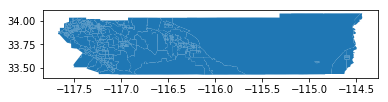

In [37]:
riverside_tracts.plot()

Coordinate Reference Systems
============================

Spatial Joins
=============

Let\'s find out which tracts have clinics.

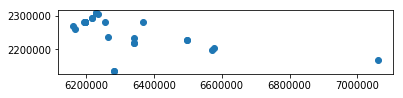

In [38]:
clinics_df.plot()

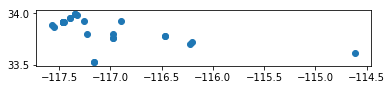

In [39]:
clinics_df.to_crs(riverside_tracts.crs).plot()

In [40]:
# convert crs of clinics to match that of tracts
clinics_df = clinics_df.to_crs(riverside_tracts.crs)

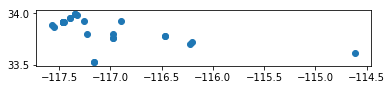

In [41]:
clinics_df.plot()

In [42]:
clinics_tracts = gpd.sjoin(clinics_df, riverside_tracts, op='within')

In [43]:
clinics_tracts.head()

,OBJECTID,SITE_TYPE,SITE_NAME,ADDRESS,CITY,ZIPCODE,PHONE,geometry,index_right,GEOID10,...,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area
0,149.0,Behavioral Health,Older Adult Services,6355 Riverside Ave,Riverside,92506,951-369-0219,POINT (-117.3882025693238 33.95198116571336),4314,06065031100,...,10.3,1613,905,708,2350,2069,2.60,2.92,0.075878,0.000283
25,146.0,Behavioral Health,Adult Mental Health Services - Central Clinic,6355 Riverside Ave,Riverside,92506,951-369-5714,POINT (-117.388194153081 33.95197775226008),4314,06065031100,...,10.3,1613,905,708,2350,2069,2.60,2.92,0.075878,0.000283
1,150.0,Behavioral Health,Children'S Treatment Services,9990 County Farm Rd,Riverside,92503,951-358-4840,POINT (-117.4567468879782 33.92002609584612),4291,06065041201,...,4.0,1064,628,436,2592,1423,4.13,3.26,0.071462,0.000252
4,152.0,Behavioral Health,Interagency Services For Families,9890 County Farm Rd,Riverside,92503,951-358-4850,POINT (-117.4554827389969 33.92001386400798),4291,06065041201,...,4.0,1064,628,436,2592,1423,4.13,3.26,0.071462,0.000252
5,448.0,Behavioral Health,Children'S Evaluation Services Unite,9990 County Farm Rd,Riverside,92503,951-358-7380,POINT (-117.4567468879782 33.92002609584612),4291,06065041201,...,4.0,1064,628,436,2592,1423,4.13,3.26,0.071462,0.000252


In [44]:
clinics_tracts.shape

(28, 203)

In [45]:
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [46]:
clinics_tracts.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry', 'index_right', 'GEOID10',
       ...
       'DP0200001', 'DP0210001', 'DP0210002', 'DP0210003', 'DP0220001',
       'DP0220002', 'DP0230001', 'DP0230002', 'Shape_Leng', 'Shape_Area'],
      dtype='object', length=203)

In [47]:
# GEOID10 is now attached to each clinic (i.e., tract identifier)

In [48]:
clinics_tracts[['GEOID10', 'index_right']].groupby('GEOID10').agg('count')

,index_right
GEOID10,
06065031100,2
06065040809,1
06065041201,7
06065041813,1
06065042209,3
06065042210,1
06065042512,1
06065042620,1
06065043507,2


In [49]:
clinics_tracts.groupby(['GEOID10']).size()

GEOID10
06065031100    2
06065040809    1
06065041201    7
06065041813    1
06065042209    3
06065042210    1
06065042512    1
06065042620    1
06065043507    2
06065044101    1
06065045000    2
06065045303    1
06065045501    1
06065046102    1
06065049600    2
06065051300    1
dtype: int64

In [50]:
clinics_tracts.groupby(['GEOID10']).size().reset_index(name='clinics')

,GEOID10,clinics
0,06065031100,2
1,06065040809,1
2,06065041201,7
3,06065041813,1
4,06065042209,3
5,06065042210,1
6,06065042512,1
7,06065042620,1
8,06065043507,2
9,06065044101,1


In [51]:
twc = clinics_tracts.groupby(['GEOID10']).size().reset_index(name='clinics')

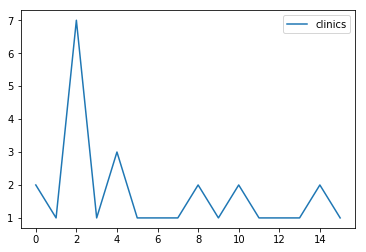

In [52]:
twc.plot()

In [53]:
riverside_tracts_clinics = riverside_tracts.merge(twc, how='left', on='GEOID10')

In [54]:
riverside_tracts_clinics.head()

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,...,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,geometry,clinics
0,06065042012,Census Tract 420.12,2687173.0,0.0,+33.9108776,-117.3205065,6242,420,545,620,...,1142,826,3927,2299,3.44,2.78,0.095958,0.000262,"POLYGON ((-117.300465 33.91310800000002, -117....",NaN
1,06065041911,Census Tract 419.11,70257842.0,0.0,+33.7428832,-117.4957943,10258,840,844,806,...,2881,430,8710,1543,3.02,3.59,0.466106,0.006836,"POLYGON ((-117.5101979999999 33.800273, -117.5...",NaN
2,06065041910,Census Tract 419.10,11167489.0,64225.0,+33.7892199,-117.4949771,6342,404,453,447,...,1823,350,5177,1165,2.84,3.33,0.200974,0.001093,POLYGON ((-117.5029849999999 33.82494899999995...,NaN
3,06065040816,Census Tract 408.16,1788821.0,0.0,+33.9024569,-117.5246107,2594,162,161,227,...,688,171,2133,451,3.10,2.64,0.082444,0.000174,"POLYGON ((-117.515118 33.90096800000009, -117....",NaN
4,06065040815,Census Tract 408.15,1266779.0,0.0,+33.8930776,-117.5114997,3586,231,235,257,...,756,399,2462,1124,3.26,2.82,0.050637,0.000123,"POLYGON ((-117.503863 33.89735700000011, -117....",NaN


In [55]:
riverside_tracts_clinics.fillna(value=0, inplace=True)

In [56]:
riverside_tracts_clinics.head()

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,...,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,geometry,clinics
0,06065042012,Census Tract 420.12,2687173.0,0.0,+33.9108776,-117.3205065,6242,420,545,620,...,1142,826,3927,2299,3.44,2.78,0.095958,0.000262,"POLYGON ((-117.300465 33.91310800000002, -117....",0.0
1,06065041911,Census Tract 419.11,70257842.0,0.0,+33.7428832,-117.4957943,10258,840,844,806,...,2881,430,8710,1543,3.02,3.59,0.466106,0.006836,"POLYGON ((-117.5101979999999 33.800273, -117.5...",0.0
2,06065041910,Census Tract 419.10,11167489.0,64225.0,+33.7892199,-117.4949771,6342,404,453,447,...,1823,350,5177,1165,2.84,3.33,0.200974,0.001093,POLYGON ((-117.5029849999999 33.82494899999995...,0.0
3,06065040816,Census Tract 408.16,1788821.0,0.0,+33.9024569,-117.5246107,2594,162,161,227,...,688,171,2133,451,3.10,2.64,0.082444,0.000174,"POLYGON ((-117.515118 33.90096800000009, -117....",0.0
4,06065040815,Census Tract 408.15,1266779.0,0.0,+33.8930776,-117.5114997,3586,231,235,257,...,756,399,2462,1124,3.26,2.82,0.050637,0.000123,"POLYGON ((-117.503863 33.89735700000011, -117....",0.0


In [57]:
riverside_tracts_clinics['clinics'].sum()

28.0

Writing Shapefiles
==================

In [58]:
# save to a new shapefile
riverside_tracts_clinics.to_file('data/clinics.shp')

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Introduction to GeoPandas</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.